# Петар и вук: Увод у учење путем појачања

У овом туторијалу ћемо научити како применити учење путем појачања на проблем проналажења пута. Овај сценарио је инспирисан музичком бајком [Петар и вук](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) руског композитора [Сергеја Прокофјева](https://en.wikipedia.org/wiki/Sergei_Prokofiev). То је прича о младом пиониру Петру, који храбро излази из своје куће на шумску чистину да би јурио вука. Тренираћемо алгоритме машинског учења који ће помоћи Петру да истражи околину и направи оптималну навигациону мапу.

Прво, хајде да увеземо неколико корисних библиотека:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Преглед учења путем појачања

**Учење путем појачања** (RL) је техника учења која нам омогућава да научимо оптимално понашање **агента** у неком **окружењу** кроз извођење многих експеримената. Агент у овом окружењу треба да има неки **циљ**, који је дефинисан помоћу **функције награде**.

## Окружење

За једноставност, хајде да замислимо Петеров свет као квадратну таблу величине `width` x `height`. Свака ћелија на овој табли може бити:
* **земља**, по којој Петер и друга створења могу ходати
* **вода**, по којој, очигледно, не можете ходати
* **дрво** или **трава** - место где можете мало одморити
* **јабука**, која представља нешто што би Петер радо пронашао да би се нахранио
* **вук**, који је опасан и треба га избегавати

Да бисмо радили са окружењем, дефинисаћемо класу под називом `Board`. Да не бисмо превише оптеретили овај нотебук, сав код за рад са таблом преместили смо у посебан модул `rlboard`, који ћемо сада увозити. Можете погледати унутар овог модула за више детаља о интерним аспектима имплементације.


In [2]:
from rlboard import *

Хајде сада да направимо насумичну таблу и видимо како изгледа:


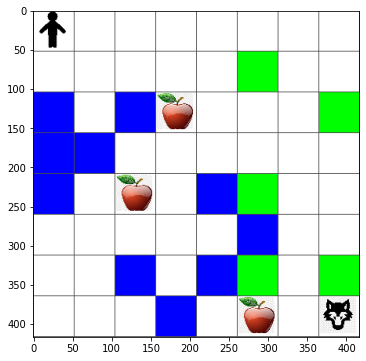

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Акције и Политика

У нашем примеру, циљ Петра би био да пронађе јабуку, избегавајући вука и друге препреке. Да би то урадио, он може суштински да се креће док не пронађе јабуку. Због тога, на било којој позицији може да изабере једну од следећих акција: горе, доле, лево и десно. Те акције ћемо дефинисати као речник и повезати их са паровима одговарајућих промена координата. На пример, кретање десно (`R`) би одговарало пару `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Стратегија нашег агента (Петар) дефинисана је такозваном **политиком**. Хајде да размотримо најједноставнију политику која се зове **случајно кретање**.

## Случајно кретање

Хајде прво да решимо наш проблем применом стратегије случајног кретања.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Хајде да спроведемо експеримент случајног хода неколико пута и видимо просечан број корака:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Функција награђивања

Да бисмо нашу политику учинили интелигентнијом, потребно је да разумемо који потези су "бољи" од других.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Лернинг

Направите Q-Табелу, или вишедимензионални низ. Пошто наша табла има димензије `width` x `height`, можемо представити Q-Табелу помоћу numpy низа са обликом `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Проследите Q-табелу функцији за цртање како бисте визуализовали табелу на табли:


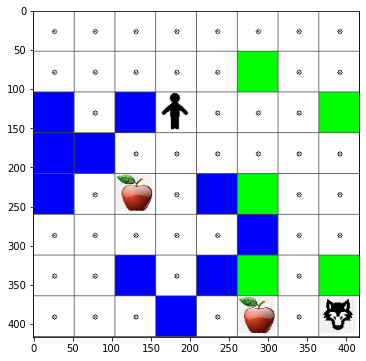

In [9]:
m.plot(Q)

## Суштина Q-Learning-а: Белманова једначина и алгоритам учења

Напишите псеудо-код за наш алгоритам учења:

* Иницијализујте Q-табелу Q са једнаким вредностима за сва стања и акције
* Поставите стопу учења $\alpha\leftarrow 1$
* Поновите симулацију више пута
   1. Почните са случајне позиције
   1. Понављајте
        1. Изаберите акцију $a$ у стању $s$
        2. Извршите акцију преласком у ново стање $s'$
        3. Ако наиђемо на услов за крај игре, или је укупна награда сувише мала - изађите из симулације  
        4. Израчунајте награду $r$ у новом стању
        5. Ажурирајте Q-функцију према Белмановој једначини: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Ажурирајте укупну награду и смањите $\alpha$.

## Експлоатација vs. Експлорација

Најбољи приступ је пронаћи баланс између експлорације и експлоатације. Како више учимо о нашем окружењу, вероватније је да ћемо следити оптималну путању, али је важно да повремено изаберемо непознат пут.

## Python имплементација

Сада смо спремни да имплементирамо алгоритам учења. Пре тога, потребна нам је и функција која ће произвољне бројеве у Q-табели претворити у вектор вероватноћа за одговарајуће акције:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Малој количини `eps` додајемо оригиналном вектору како бисмо избегли дељење са 0 у почетном случају, када су све компоненте вектора идентичне.

Стварни алгоритам учења покренућемо за 5000 експеримената, који се такође називају **епохе**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Након извршавања овог алгоритма, Q-табела би требало да буде ажурирана вредностима које дефинишу привлачност различитих акција у сваком кораку. Визуелизујте табелу овде:


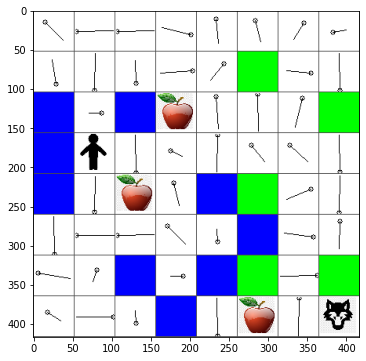

In [12]:
m.plot(Q)

## Провера политике

Пошто Q-табела приказује „атрактивност“ сваке акције у сваком стању, веома је једноставно користити је за дефинисање ефикасне навигације у нашем свету. У најједноставнијем случају, можемо једноставно изабрати акцију која одговара највишој вредности у Q-табели:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Ако покренете горњи код неколико пута, можда ћете приметити да понекад само "заглави", и потребно је да притиснете дугме STOP у бележници како бисте га прекинули.

> **Задатак 1:** Измените функцију `walk` тако да ограничи максималну дужину пута на одређени број корака (на пример, 100), и посматрајте како горњи код повремено враћа ову вредност.

> **Задатак 2:** Измените функцију `walk` тако да се не враћа на места на којима је већ била раније. Ово ће спречити да `walk` упадне у петљу, али агент и даље може завршити "заробљен" на локацији са које не може да побегне.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


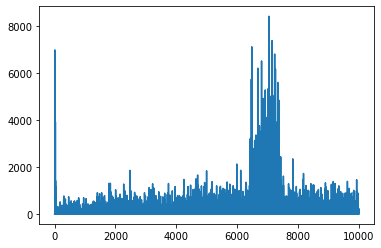

In [15]:
plt.plot(lpath)

Оно што овде видимо је да је на почетку просечна дужина пута порасла. Ово је вероватно због чињенице да када ништа не знамо о окружењу – вероватно ћемо се заглавити у лошим стањима, као што су вода или вук. Како учимо више и почнемо да користимо то знање, можемо истраживати окружење дуже, али и даље не знамо добро где се налазе јабуке.

Када научимо довољно, агенту постаје лакше да постигне циљ, и дужина пута почиње да се смањује. Међутим, и даље смо отворени за истраживање, па често одступамо од најбољег пута и истражујемо нове опције, што чини пут дужим од оптималног.

Оно што такође примећујемо на овом графику је да је у једном тренутку дужина нагло порасла. Ово указује на стохастичку природу процеса и на то да у неком тренутку можемо „покварити“ коефицијенте Q-табеле, тако што ћемо их преписати новим вредностима. Ово би идеално требало минимизовати смањењем стопе учења (тј. пред крај обуке подешавамо вредности Q-табеле само за малу вредност).

Уопштено, важно је запамтити да успех и квалитет процеса учења значајно зависе од параметара, као што су стопа учења, смањење стопе учења и фактор дисконтовања. Ови параметри се често називају **хиперпараметри**, како би се разликовали од **параметара** које оптимизујемо током обуке (нпр. коефицијенти Q-табеле). Процес проналажења најбољих вредности хиперпараметара назива се **оптимизација хиперпараметара**, и заслужује посебну тему.


## Вежба
#### Реалнији свет Петра и вука

У нашој ситуацији, Петар је могао да се креће готово без умарања или глади. У реалнијем свету, он мора с времена на време да седне и одмори се, као и да се храни. Хајде да наш свет учинимо реалнијим применом следећих правила:

1. Крећући се са једног места на друго, Петар губи **енергију** и добија одређени ниво **умора**.
2. Петар може да повећа енергију једући јабуке.
3. Петар може да се ослободи умора одмарајући се испод дрвета или на трави (тј. уласком на локацију табле са дрветом или травом - зелено поље).
4. Петар мора да пронађе и убије вука.
5. Да би убио вука, Петар мора да има одређене нивое енергије и умора, иначе губи битку.

Измените функцију награде изнад у складу са правилима игре, покрените алгоритам за учење појачања како бисте научили најбољу стратегију за победу у игри, и упоредите резултате насумичног кретања са вашим алгоритмом у смислу броја добијених и изгубљених игара.

> **Напомена**: Можда ћете морати да прилагодите хиперпараметре да би све функционисало, посебно број епоха. Пошто је успех у игри (борба са вуком) редак догађај, можете очекивати много дуже време тренинга.



---

**Одрицање од одговорности**:  
Овај документ је преведен коришћењем услуге за превођење помоћу вештачке интелигенције [Co-op Translator](https://github.com/Azure/co-op-translator). Иако тежимо тачности, молимо вас да имате у виду да аутоматски преводи могу садржати грешке или нетачности. Оригинални документ на изворном језику треба сматрати ауторитативним извором. За критичне информације препоручује се професионални превод од стране људи. Не сносимо одговорност за било каква неспоразумевања или погрешна тумачења која могу произаћи из коришћења овог превода.
